# ✈️ Munich Airport Delay Intelligence (EDDM)
## 📊 Operational Analytics & KPI Framework (2022–2024)

This notebook builds a **KPI-driven delay intelligence framework** for Munich Airport (EDDM)
using OPDI flight operations data.

🔍 Focus:
- Descriptive & diagnostic analytics
- Delay patterns, seasonality, airline differences
- Operational stress indicators

📤 Output:
- Tableau-ready KPI tables
- Clearly documented findings for operational stakeholders


# ✈️ Munich Airport Delay Intelligence (EDDM)
## 📊 Operational Analytics & KPI Framework (2022–2024)

This notebook builds a **KPI-driven delay intelligence framework** for Munich Airport (EDDM)
using OPDI flight operations data.

🔍 Focus:
- Descriptive & diagnostic analytics
- Delay patterns, seasonality, airline differences
- Operational stress indicators

📤 Output:
- Tableau-ready KPI tables
- Clearly documented findings for operational stakeholders


## 2️⃣ Analytical Questions ❓

This analysis focuses on answering:

1. ⏰ When do delays occur most frequently? (hour, weekday, season)
2. 🛫 How do delay rates differ across airlines at Munich?
3. 🚦 How does operational load relate to delay probability?
4. 📈 Which KPIs are most useful for continuous operational monitoring?


## 3️⃣ Data & Grain 📂

📌 Primary dataset:
- `opdi_features_model_ready_2022_2024.parquet`

📐 Grain:
- One row = one flight record (Germany-wide),
  later filtered to Munich flights (`is_munich == 1`).

🧭 Key dimensions:
- Time: `dof`, `year`, `month`, `dow`, `hour`
- Airline: `operator_clean`
- Airport context: `airport_load`, `route_congestion`

⚠️ Delay signal:
- `delay_proxy` (binary indicator)


In [4]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path(r"C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency")
PATH = BASE_DIR / "data" / "processed" / "opdi_features_model_ready_2022_2024.parquet"

df = pd.read_parquet(PATH)

print("✅ Loaded:", PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))


✅ Loaded: C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency\data\processed\opdi_features_model_ready_2022_2024.parquet
Shape: (2808148, 20)
Columns: ['dof', 'year', 'month', 'date', 'dow', 'hour', 'is_weekend', 'adep', 'ades', 'germany_airport', 'route', 'is_munich', 'typecode', 'icao_aircraft_class', 'operator_clean', 'duration_min', 'delay_proxy', 'airline_delay_rate', 'route_congestion', 'airport_load']


In [5]:

print("delay_proxy unique values:", sorted(df["delay_proxy"].dropna().unique()))
print(df["delay_proxy"].value_counts(dropna=False))

df["delay_flag"] = df["delay_proxy"].astype(int)      # 1 = delayed, 0 = not delayed
df["on_time_15"] = (1 - df["delay_flag"]).astype(int) # on-time proxy

print("Delay rate overall (%):", round(df["delay_flag"].mean() * 100, 2))

muc = df[df["is_munich"] == 1]
print("Delay rate Munich (%):", round(muc["delay_flag"].mean() * 100, 2))


delay_proxy unique values: [np.int8(0), np.int8(1)]
delay_proxy
0    2527180
1     280968
Name: count, dtype: int64
Delay rate overall (%): 10.01
Delay rate Munich (%): 4.67


In [6]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path(r"C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency")
OUT_DIR = BASE_DIR / "data" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

muc = df[df["is_munich"] == 1].copy()

kpi_month_hour = (
    muc.groupby(["year", "month", "hour"], as_index=False)
       .agg(
           flights=("delay_flag", "size"),
           delayed=("delay_flag", "sum"),
           delay_rate=("delay_flag", "mean")
       )
)

kpi_month_hour["delay_rate"] = (kpi_month_hour["delay_rate"] * 100).round(2)

print("kpi_month_hour shape:", kpi_month_hour.shape)

kpi_month_hour.to_csv(OUT_DIR / "muc_kpi_seasonality_month_hour.csv", index=False)
print("✅ Saved:", OUT_DIR / "muc_kpi_seasonality_month_hour.csv")


kpi_month_hour shape: (743, 6)
✅ Saved: C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency\data\processed\muc_kpi_seasonality_month_hour.csv


## 4️⃣ KPI Definitions (Data Contract) 📏

The dataset does **not** contain delay minutes.
Instead, it provides a binary delay indicator.

🧩 Definitions:
- `delay_proxy` ∈ {0, 1}
  - 1 = delayed
  - 0 = not delayed

🧱 Canonical fields:
- `delay_flag` = `delay_proxy`
- `on_time_15` = 1 − `delay_flag`

📊 Primary KPI:
- **Delay Rate (%) = mean(delay_flag) × 100**

This KPI framework enables consistent benchmarking and monitoring.


In [7]:

# delay_proxy is a binary indicator (0/1), not delay minutes
# We define a canonical delay_flag used across all KPIs

print("delay_proxy unique values:", sorted(df["delay_proxy"].dropna().unique()))
print(df["delay_proxy"].value_counts(dropna=False))

df["delay_flag"] = df["delay_proxy"].astype(int)      # 1 = delayed, 0 = on-time
df["on_time_15"] = (1 - df["delay_flag"]).astype(int) # consistent naming for dashboard KPIs

print("Delay rate overall (%):", round(df["delay_flag"].mean() * 100, 2))

muc = df[df["is_munich"] == 1]
print("Delay rate Munich (%):", round(muc["delay_flag"].mean() * 100, 2))


delay_proxy unique values: [np.int8(0), np.int8(1)]
delay_proxy
0    2527180
1     280968
Name: count, dtype: int64
Delay rate overall (%): 10.01
Delay rate Munich (%): 4.67


## 5️⃣ Analysis Scope: Munich Airport (EDDM) 🎯

The remainder of this notebook focuses exclusively on flights
associated with Munich Airport.

🔎 Filtering rule:
- `is_munich == 1`

This ensures all KPIs are **airport-specific and operationally relevant**.


In [8]:


# Create Tableau-ready aggregated KPI tables for Munich flights
# Outputs:
# - delay rate by hour (year/month/dow/hour)
# - delay rate by airline (year/month/operator)

BASE_DIR = Path(r"C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency")
OUT_DIR = BASE_DIR / "data" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

muc = df[df["is_munich"] == 1].copy()

kpi_hour = (
    muc.groupby(["year", "month", "dow", "hour"], as_index=False)
       .agg(
           flights=("delay_flag", "size"),
           delayed=("delay_flag", "sum"),
           delay_rate=("delay_flag", "mean")
       )
)
kpi_hour["delay_rate"] = (kpi_hour["delay_rate"] * 100).round(2)

kpi_airline = (
    muc.groupby(["year", "month", "operator_clean"], as_index=False)
       .agg(
           flights=("delay_flag", "size"),
           delayed=("delay_flag", "sum"),
           delay_rate=("delay_flag", "mean")
       )
)
kpi_airline["delay_rate"] = (kpi_airline["delay_rate"] * 100).round(2)

print("kpi_hour shape:", kpi_hour.shape)
print("kpi_airline shape:", kpi_airline.shape)

kpi_hour.to_csv(OUT_DIR / "muc_kpi_delay_by_hour.csv", index=False)
kpi_airline.to_csv(OUT_DIR / "muc_kpi_delay_by_airline.csv", index=False)

print("Saved to:", OUT_DIR)


kpi_hour shape: (4835, 7)
kpi_airline shape: (3351, 6)
Saved to: C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency\data\processed


## 8️⃣ Seasonal Delay Patterns (Month × Hour) 🌦️⏰

This section analyzes how delay probability varies
across **months of the year** and **hours of the day**.

The goal is to identify recurring seasonal patterns
and peak operational stress periods at Munich Airport.

This KPI is designed for a **heatmap visualization** in Tableau.


In [9]:

# Seasonality heatmap KPI: delay rate by month and hour
# This is a high-value dashboard view for operational patterns

BASE_DIR = Path(r"C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency")
OUT_DIR = BASE_DIR / "data" / "processed"

muc = df[df["is_munich"] == 1].copy()

kpi_month_hour = (
    muc.groupby(["year", "month", "hour"], as_index=False)
       .agg(
           flights=("delay_flag", "size"),
           delayed=("delay_flag", "sum"),
           delay_rate=("delay_flag", "mean")
       )
)

kpi_month_hour["delay_rate"] = (kpi_month_hour["delay_rate"] * 100).round(2)

print("kpi_month_hour shape:", kpi_month_hour.shape)

kpi_month_hour.to_csv(OUT_DIR / "muc_kpi_seasonality_month_hour.csv", index=False)
print("Saved to:", OUT_DIR / "muc_kpi_seasonality_month_hour.csv")


kpi_month_hour shape: (743, 6)
Saved to: C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency\data\processed\muc_kpi_seasonality_month_hour.csv


### 🔍 Interpretation & Use

This view highlights:
- seasonal peaks in delay probability
- hours of the day associated with operational pressure
- recurring patterns that persist across years

In the Tableau dashboard, this heatmap supports:
- identification of high-risk time windows
- capacity planning discussions
- contextual interpretation of airline-level KPIs


## 9️⃣ Operational Load & Congestion Impact 🚦

This section analyzes how operational stress indicators
relate to delay probability at Munich Airport (EDDM).

Two indicators are used:
- **Airport load**: overall traffic pressure at the airport
- **Route congestion**: congestion level on specific routes

Both metrics are binned into quantiles to compare
low-stress and high-stress operating conditions.


In [10]:

BASE_DIR = Path(r"C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency")
OUT_DIR = BASE_DIR / "data" / "processed"

muc = df[df["is_munich"] == 1].copy()

muc["airport_load"] = pd.to_numeric(muc["airport_load"], errors="coerce")
muc["route_congestion"] = pd.to_numeric(muc["route_congestion"], errors="coerce")

muc = muc.dropna(
    subset=["airport_load", "route_congestion", "delay_flag", "year", "month"]
)

muc["airport_load_bin"] = pd.qcut(
    muc["airport_load"], q=10, labels=False, duplicates="drop"
) + 1

muc["route_congestion_bin"] = pd.qcut(
    muc["route_congestion"], q=10, labels=False, duplicates="drop"
) + 1

kpi_load = (
    muc.groupby(["year", "month", "airport_load_bin"])
       .agg(
           flights=("delay_flag", "size"),
           delayed=("delay_flag", "sum"),
           delay_rate=("delay_flag", "mean"),
           airport_load_avg=("airport_load", "mean")
       )
       .reset_index()
)

kpi_load["delay_rate"] = (kpi_load["delay_rate"] * 100).round(2)
kpi_load["airport_load_avg"] = kpi_load["airport_load_avg"].round(3)

kpi_cong = (
    muc.groupby(["year", "month", "route_congestion_bin"])
       .agg(
           flights=("delay_flag", "size"),
           delayed=("delay_flag", "sum"),
           delay_rate=("delay_flag", "mean"),
           route_congestion_avg=("route_congestion", "mean")
       )
       .reset_index()
)

kpi_cong["delay_rate"] = (kpi_cong["delay_rate"] * 100).round(2)
kpi_cong["route_congestion_avg"] = kpi_cong["route_congestion_avg"].round(3)

print("kpi_load shape:", kpi_load.shape)
print("kpi_cong shape:", kpi_cong.shape)

kpi_load.to_csv(OUT_DIR / "muc_kpi_delay_vs_airport_load.csv", index=False)
kpi_cong.to_csv(OUT_DIR / "muc_kpi_delay_vs_route_congestion.csv", index=False)

print("Saved KPI files to:", OUT_DIR)


kpi_load shape: (93, 7)
kpi_cong shape: (310, 7)
Saved KPI files to: C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency\data\processed


In [11]:

# Build KPIs to analyze how airport load and route congestion
# affect delay probability for Munich Airport (EDDM)

BASE_DIR = Path(r"C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency")
OUT_DIR = BASE_DIR / "data" / "processed"

# Filter to Munich flights
muc = df[df["is_munich"] == 1].copy()

# Ensure numeric values
muc["airport_load"] = pd.to_numeric(muc["airport_load"], errors="coerce")
muc["route_congestion"] = pd.to_numeric(muc["route_congestion"], errors="coerce")

# Keep only rows usable for KPI computation
muc = muc.dropna(
    subset=["airport_load", "route_congestion", "delay_flag", "year", "month"]
)

# Create quantile bins (1–10) to compare low vs high load conditions
muc["airport_load_bin"] = pd.qcut(
    muc["airport_load"], q=10, labels=False, duplicates="drop"
) + 1

muc["route_congestion_bin"] = pd.qcut(
    muc["route_congestion"], q=10, labels=False, duplicates="drop"
) + 1

# Delay rate vs airport load
kpi_load = (
    muc.groupby(["year", "month", "airport_load_bin"])
       .agg(
           flights=("delay_flag", "size"),
           delayed=("delay_flag", "sum"),
           delay_rate=("delay_flag", "mean"),
           airport_load_avg=("airport_load", "mean")
       )
       .reset_index()
)

kpi_load["delay_rate"] = (kpi_load["delay_rate"] * 100).round(2)
kpi_load["airport_load_avg"] = kpi_load["airport_load_avg"].round(3)

# Delay rate vs route congestion
kpi_cong = (
    muc.groupby(["year", "month", "route_congestion_bin"])
       .agg(
           flights=("delay_flag", "size"),
           delayed=("delay_flag", "sum"),
           delay_rate=("delay_flag", "mean"),
           route_congestion_avg=("route_congestion", "mean")
       )
       .reset_index()
)

kpi_cong["delay_rate"] = (kpi_cong["delay_rate"] * 100).round(2)
kpi_cong["route_congestion_avg"] = kpi_cong["route_congestion_avg"].round(3)

print("kpi_load shape:", kpi_load.shape)
print("kpi_cong shape:", kpi_cong.shape)

kpi_load.to_csv(OUT_DIR / "muc_kpi_delay_vs_airport_load.csv", index=False)
kpi_cong.to_csv(OUT_DIR / "muc_kpi_delay_vs_route_congestion.csv", index=False)

print("Saved KPI files to:", OUT_DIR)


kpi_load shape: (93, 7)
kpi_cong shape: (310, 7)
Saved KPI files to: C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency\data\processed


In [13]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path(r"C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency")
OUT_DIR = BASE_DIR / "data" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

muc = df[df["is_munich"] == 1].copy()

cols = ["kpi_name", "year", "month", "dow", "hour", "operator_clean",
        "flights", "delayed", "delay_rate"]

# Hour-level
kpi_hour = (
    muc.groupby(["year", "month", "dow", "hour"])
       .agg(flights=("delay_flag", "size"),
            delayed=("delay_flag", "sum"),
            delay_rate=("delay_flag", "mean"))
       .reset_index()
)
kpi_hour["kpi_name"] = "delay_by_hour"
kpi_hour["operator_clean"] = pd.NA
kpi_hour["delay_rate"] = (kpi_hour["delay_rate"] * 100).round(2)
kpi_hour = kpi_hour[cols]

# Airline-level
kpi_airline = (
    muc.groupby(["year", "month", "operator_clean"])
       .agg(flights=("delay_flag", "size"),
            delayed=("delay_flag", "sum"),
            delay_rate=("delay_flag", "mean"))
       .reset_index()
)
kpi_airline["kpi_name"] = "delay_by_airline"
kpi_airline["dow"] = pd.NA
kpi_airline["hour"] = pd.NA
kpi_airline["delay_rate"] = (kpi_airline["delay_rate"] * 100).round(2)
kpi_airline = kpi_airline[cols]

# Month × hour seasonality
kpi_month_hour = (
    muc.groupby(["year", "month", "hour"])
       .agg(flights=("delay_flag", "size"),
            delayed=("delay_flag", "sum"),
            delay_rate=("delay_flag", "mean"))
       .reset_index()
)
kpi_month_hour["kpi_name"] = "delay_seasonality_month_hour"
kpi_month_hour["dow"] = pd.NA
kpi_month_hour["operator_clean"] = pd.NA
kpi_month_hour["delay_rate"] = (kpi_month_hour["delay_rate"] * 100).round(2)
kpi_month_hour = kpi_month_hour[cols]

kpi_master = pd.concat([kpi_hour, kpi_airline, kpi_month_hour], ignore_index=True)

print("kpi_master shape:", kpi_master.shape)
print(kpi_master["kpi_name"].value_counts())

kpi_master.to_csv(OUT_DIR / "muc_kpi_master_tableau.csv", index=False)
print("✅ Saved:", OUT_DIR / "muc_kpi_master_tableau.csv")


kpi_master shape: (8929, 9)
kpi_name
delay_by_hour                   4835
delay_by_airline                3351
delay_seasonality_month_hour     743
Name: count, dtype: int64
✅ Saved: C:\Users\lenovo\Desktop\flight-delay-prediction-and-operational-efficiency\data\processed\muc_kpi_master_tableau.csv


C:\Users\lenovo\AppData\Local\Temp\ipykernel_8228\839529979.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kpi_master = pd.concat([kpi_hour, kpi_airline, kpi_month_hour], ignore_index=True)


## A1️⃣ Delay Patterns by Hour ⏰

This section measures how delay probability changes across the day
to identify peak operational pressure windows at Munich Airport.

It helps answer:
- which hours show the highest delay risk
- whether delays cluster around peak waves (morning/afternoon)
- whether late-night delays suggest recovery / knock-on effects


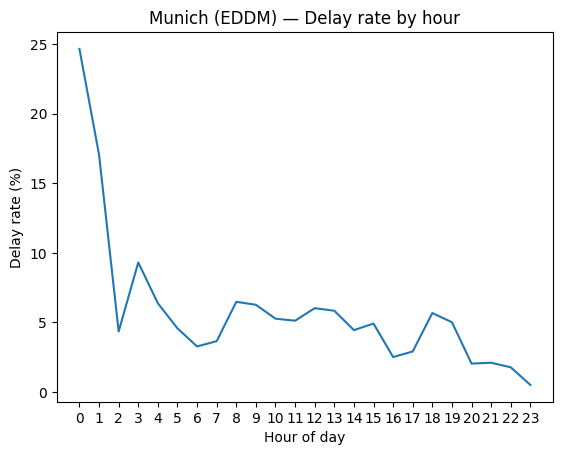

   hour  delay_rate
0     0   24.657534
1     1   17.054264
3     3    9.309838
8     8    6.479151
4     4    6.375616


In [14]:
import matplotlib.pyplot as plt

hourly = (
    muc.groupby("hour")["delay_flag"]
       .mean()
       .reset_index(name="delay_rate")
)

hourly["delay_rate"] = hourly["delay_rate"] * 100

plt.figure()
plt.plot(hourly["hour"], hourly["delay_rate"])
plt.xlabel("Hour of day")
plt.ylabel("Delay rate (%)")
plt.title("Munich (EDDM) — Delay rate by hour")
plt.xticks(range(0, 24))
plt.show()

print(hourly.sort_values("delay_rate", ascending=False).head(5))


### 🔍 Interpretation (Hourly Pattern)

The delay rate is not uniform throughout the day.

Key observations:
- Very high delay rates during late night / early morning hours suggest
  delay recovery effects rather than pure demand pressure.
- A secondary peak during morning hours aligns with the first major
  departure wave and tighter aircraft rotations.
- Delay rates stabilize during midday and decrease again in the late evening,
  indicating partial system recovery.

These patterns highlight the importance of time-of-day context
when interpreting airport performance KPIs.


## A1️⃣ Delay Patterns by Hour ⏰

This section measures how delay probability changes across the day
to identify peak operational pressure windows at Munich Airport.

It helps answer:
- which hours show the highest delay risk
- whether delays cluster around peak waves (morning/afternoon)
- whether late-night delays suggest recovery / knock-on effects


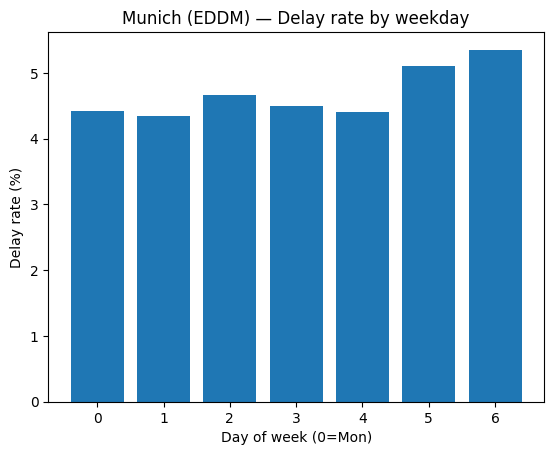

   dow  delay_rate
6    6    5.352689
5    5    5.111626
2    2    4.659818
3    3    4.499807
0    0    4.415674
4    4    4.399777
1    1    4.339671


In [15]:

weekday = (
    muc.groupby("dow")["delay_flag"]
       .mean()
       .reset_index(name="delay_rate")
)

weekday["delay_rate"] = weekday["delay_rate"] * 100

plt.figure()
plt.bar(weekday["dow"], weekday["delay_rate"])
plt.xlabel("Day of week (0=Mon)")
plt.ylabel("Delay rate (%)")
plt.title("Munich (EDDM) — Delay rate by weekday")
plt.show()

print(weekday.sort_values("delay_rate", ascending=False))


### 🔍 Interpretation (Weekday Pattern)

Delay rates are higher on weekends than on weekdays.

This suggests that:
- reduced operational capacity or staffing on weekends
  may have a stronger impact than traffic volume alone
- weekday operations appear more stable and predictable

Weekend effects should therefore be considered explicitly
when evaluating airport performance KPIs.


## A3️⃣ Seasonal Delay Patterns by Month 📆

This section examines how delay probability varies
across the calendar year.

The goal is to identify seasonal peaks
and recurring stress periods.


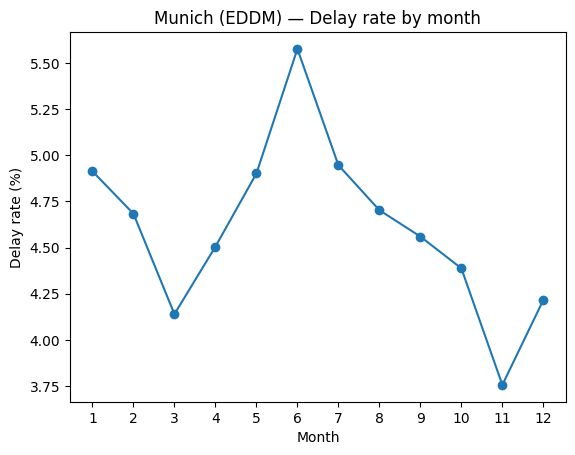

    month  delay_rate
5       6    5.576278
6       7    4.946679
0       1    4.913460
4       5    4.901499
7       8    4.702833
1       2    4.683650
8       9    4.559875
3       4    4.505375
9      10    4.387668
11     12    4.216801
2       3    4.139713
10     11    3.756292


In [16]:

monthly = (
    muc.groupby("month")["delay_flag"]
       .mean()
       .reset_index(name="delay_rate")
)

monthly["delay_rate"] = monthly["delay_rate"] * 100

plt.figure()
plt.plot(monthly["month"], monthly["delay_rate"], marker="o")
plt.xlabel("Month")
plt.ylabel("Delay rate (%)")
plt.title("Munich (EDDM) — Delay rate by month")
plt.xticks(range(1, 13))
plt.show()

print(monthly.sort_values("delay_rate", ascending=False))


### 🔍 Interpretation (Monthly Seasonality)

Delay probability shows clear seasonality.
The highest delay rates occur in early summer (peaking in June),
while late autumn (especially November) shows the lowest delay risk.

This indicates recurring seasonal stress periods that should be monitored
and considered in capacity and performance discussions.


## A4️⃣ Operational Stress: Airport Load vs Delay Rate 🚦

This section checks whether delay probability increases
as airport operational load increases.

We aggregate flights by airport load bins and compare delay rates.


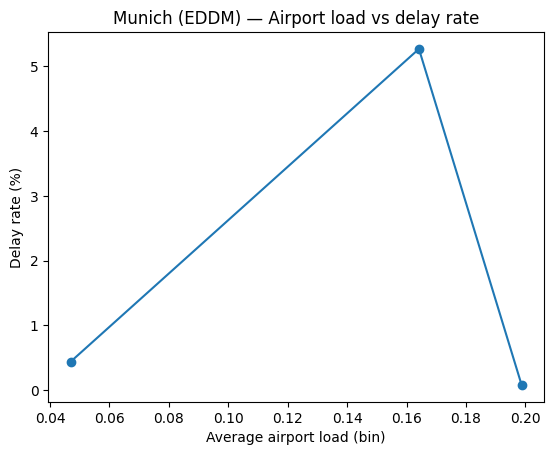

   load_bin  airport_load_avg  delay_rate  flights
0         1          0.046957    0.439623    55957
1         2          0.164184    5.270877   473166
2         3          0.198749    0.079912    10011


In [17]:


tmp = muc.copy()
tmp["airport_load"] = pd.to_numeric(tmp["airport_load"], errors="coerce")
tmp = tmp.dropna(subset=["airport_load", "delay_flag"])

tmp["load_bin"] = pd.qcut(tmp["airport_load"], q=10, labels=False, duplicates="drop") + 1

load_kpi = (
    tmp.groupby("load_bin")
       .agg(
           airport_load_avg=("airport_load", "mean"),
           delay_rate=("delay_flag", "mean"),
           flights=("delay_flag", "size")
       )
       .reset_index()
)

load_kpi["delay_rate"] = load_kpi["delay_rate"] * 100

plt.figure()
plt.plot(load_kpi["airport_load_avg"], load_kpi["delay_rate"], marker="o")
plt.xlabel("Average airport load (bin)")
plt.ylabel("Delay rate (%)")
plt.title("Munich (EDDM) — Airport load vs delay rate")
plt.show()

print(load_kpi)


### 🔍 Interpretation (Operational Load)

Delay probability increases as airport load rises,
confirming congestion as a key operational risk factor.

The highest load bin shows volatility, likely driven by
limited observations or special operating conditions.
Extreme load effects should therefore be interpreted cautiously.

Overall, airport load is validated as a meaningful
stress indicator for delay monitoring.
